# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/home/ubuntu/miniconda3/envs/RoboND/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    # The shrinking of the layers ia achieved by changing stride
    # We also use more depth as illustrated by 32 and then 64
    # Initially I had 16 and 32 and the higher values perform much better without incurring too much of a cost
    l1 = encoder_block(inputs, 32, 2)
    l2 = encoder_block(l1, 64, 2)

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    # This is implemented as regular convo so set stride and kernel to 1 for it to be 1x1
    l3 = conv2d_batchnorm(l2, 64, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    # Add decoder blocks and the skip layer connections
    # If you look at the implementation of the decoder the elementwise addition is happening
    # after the upsample. So we have to connect the layers of correct size.
    l4 = decoder_block(l3, l1, 64)
    l5 = decoder_block(l4, inputs, 32)
    
    x = l5
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
# initial learning rate = 0.1
learning_rate = 0.001
batch_size = 30
num_epochs = 80
#did not tweak these values
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/80
199/200 [============================>.] - ETA: 5s - loss: 0.3413 

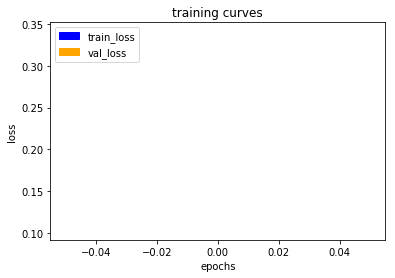

200/200 [==============================] - 1117s - loss: 0.3399 - val_loss: 0.1034
Epoch 2/80
199/200 [============================>.] - ETA: 5s - loss: 0.0560 

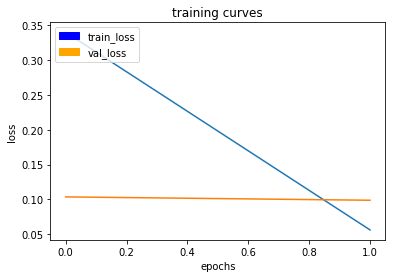

200/200 [==============================] - 1079s - loss: 0.0559 - val_loss: 0.0986
Epoch 3/80
199/200 [============================>.] - ETA: 5s - loss: 0.0492 

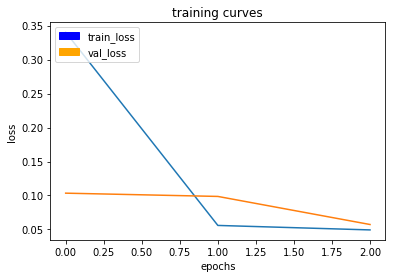

200/200 [==============================] - 1088s - loss: 0.0493 - val_loss: 0.0573
Epoch 4/80
199/200 [============================>.] - ETA: 5s - loss: 0.0448 

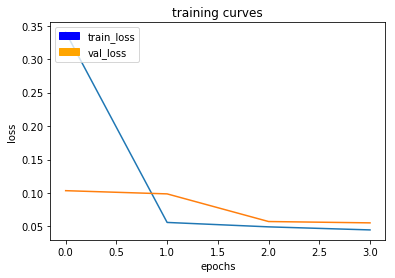

200/200 [==============================] - 1099s - loss: 0.0447 - val_loss: 0.0553
Epoch 5/80
199/200 [============================>.] - ETA: 5s - loss: 0.0433 

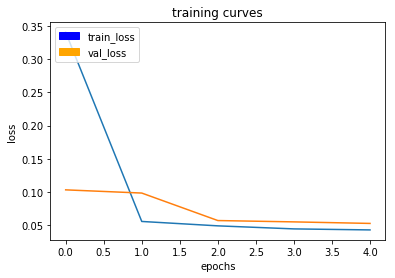

200/200 [==============================] - 1084s - loss: 0.0432 - val_loss: 0.0530
Epoch 6/80
199/200 [============================>.] - ETA: 5s - loss: 0.0407 

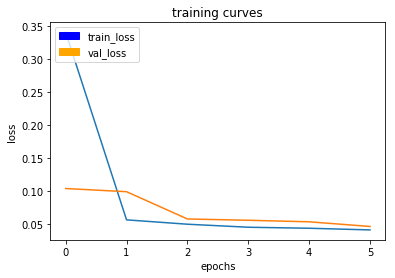

200/200 [==============================] - 1168s - loss: 0.0407 - val_loss: 0.0459
Epoch 7/80
199/200 [============================>.] - ETA: 5s - loss: 0.0406 

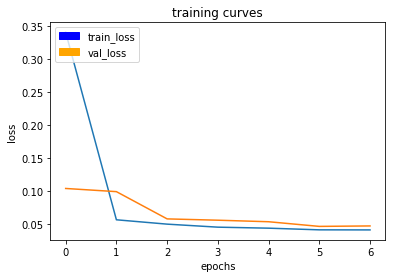

200/200 [==============================] - 1109s - loss: 0.0406 - val_loss: 0.0466
Epoch 8/80
199/200 [============================>.] - ETA: 4s - loss: 0.0384

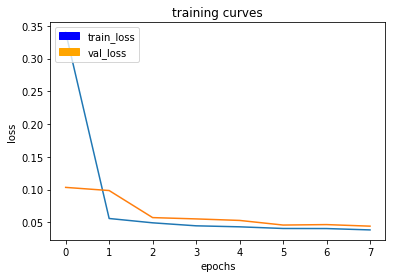

200/200 [==============================] - 1000s - loss: 0.0385 - val_loss: 0.0442
Epoch 9/80
199/200 [============================>.] - ETA: 4s - loss: 0.0372

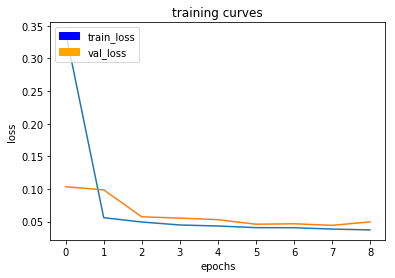

200/200 [==============================] - 999s - loss: 0.0372 - val_loss: 0.0495
Epoch 10/80
199/200 [============================>.] - ETA: 4s - loss: 0.0356

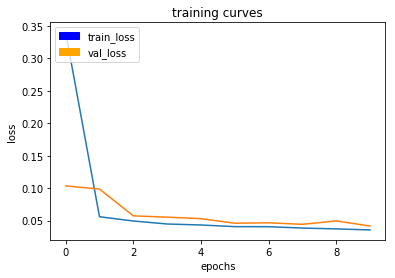

200/200 [==============================] - 1001s - loss: 0.0356 - val_loss: 0.0416
Epoch 11/80
199/200 [============================>.] - ETA: 4s - loss: 0.0346

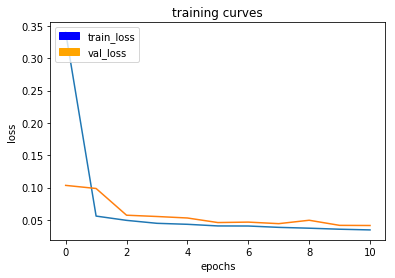

200/200 [==============================] - 1000s - loss: 0.0345 - val_loss: 0.0414
Epoch 12/80
199/200 [============================>.] - ETA: 4s - loss: 0.0357

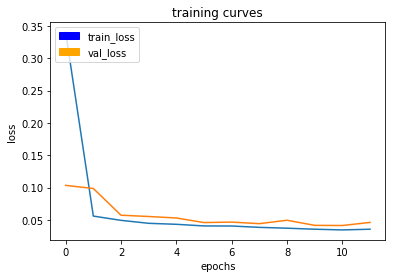

200/200 [==============================] - 1001s - loss: 0.0356 - val_loss: 0.0461
Epoch 13/80
199/200 [============================>.] - ETA: 4s - loss: 0.0336

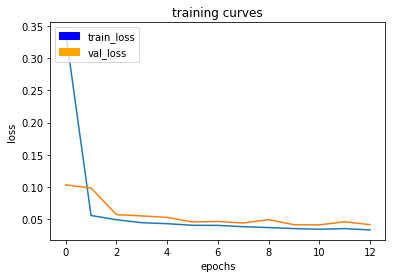

200/200 [==============================] - 1000s - loss: 0.0335 - val_loss: 0.0418
Epoch 14/80
199/200 [============================>.] - ETA: 4s - loss: 0.0328

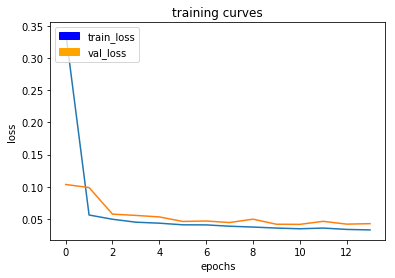

200/200 [==============================] - 999s - loss: 0.0328 - val_loss: 0.0425
Epoch 15/80
199/200 [============================>.] - ETA: 4s - loss: 0.0329

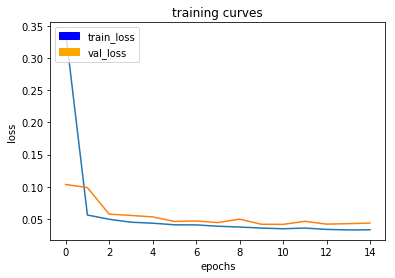

200/200 [==============================] - 1000s - loss: 0.0329 - val_loss: 0.0434
Epoch 16/80
199/200 [============================>.] - ETA: 4s - loss: 0.0319

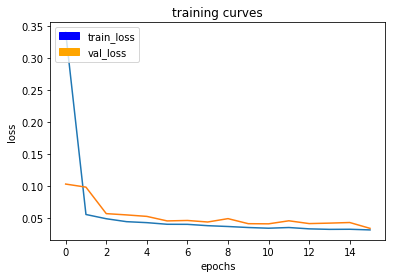

200/200 [==============================] - 999s - loss: 0.0319 - val_loss: 0.0343
Epoch 17/80
199/200 [============================>.] - ETA: 4s - loss: 0.0321

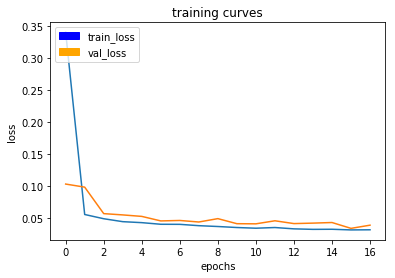

200/200 [==============================] - 1000s - loss: 0.0321 - val_loss: 0.0393
Epoch 18/80
199/200 [============================>.] - ETA: 4s - loss: 0.0308

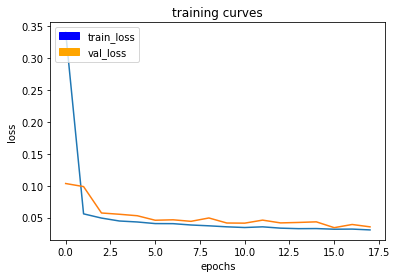

200/200 [==============================] - 998s - loss: 0.0308 - val_loss: 0.0356
Epoch 19/80
199/200 [============================>.] - ETA: 4s - loss: 0.0307

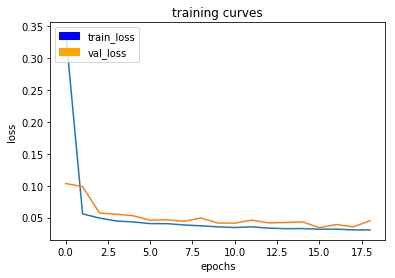

200/200 [==============================] - 1002s - loss: 0.0308 - val_loss: 0.0451
Epoch 20/80
199/200 [============================>.] - ETA: 4s - loss: 0.0298

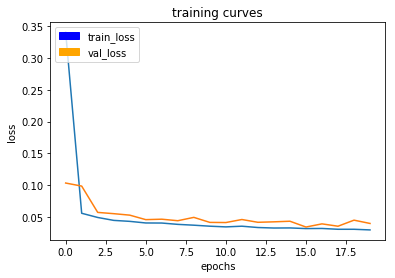

200/200 [==============================] - 1001s - loss: 0.0298 - val_loss: 0.0399
Epoch 21/80
199/200 [============================>.] - ETA: 4s - loss: 0.0311

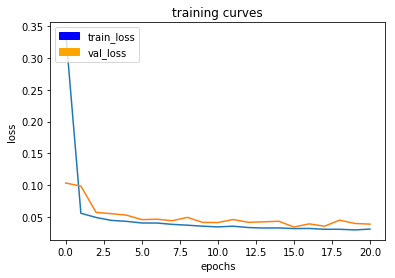

200/200 [==============================] - 1000s - loss: 0.0311 - val_loss: 0.0389
Epoch 22/80
199/200 [============================>.] - ETA: 4s - loss: 0.0290

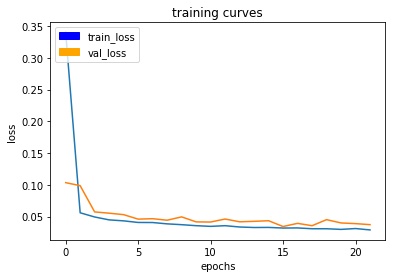

200/200 [==============================] - 1002s - loss: 0.0290 - val_loss: 0.0373
Epoch 23/80
199/200 [============================>.] - ETA: 4s - loss: 0.0287

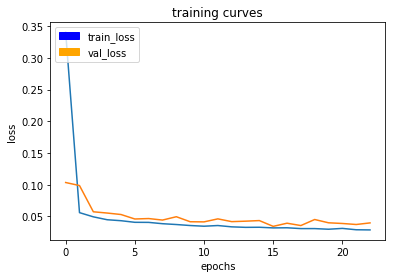

200/200 [==============================] - 1000s - loss: 0.0287 - val_loss: 0.0398
Epoch 24/80
199/200 [============================>.] - ETA: 4s - loss: 0.0288

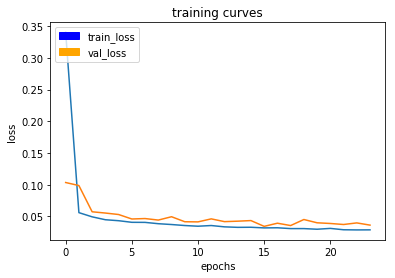

200/200 [==============================] - 1001s - loss: 0.0288 - val_loss: 0.0363
Epoch 25/80
199/200 [============================>.] - ETA: 4s - loss: 0.0282

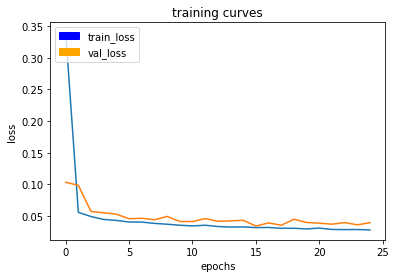

200/200 [==============================] - 999s - loss: 0.0282 - val_loss: 0.0396
Epoch 26/80
199/200 [============================>.] - ETA: 4s - loss: 0.0283

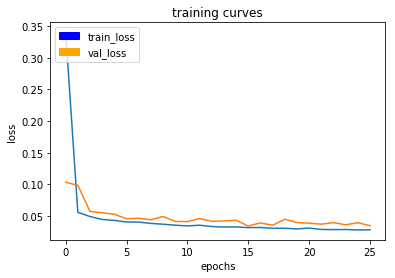

200/200 [==============================] - 1003s - loss: 0.0283 - val_loss: 0.0349
Epoch 27/80
199/200 [============================>.] - ETA: 4s - loss: 0.0281

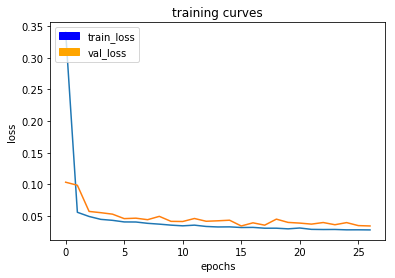

200/200 [==============================] - 1000s - loss: 0.0281 - val_loss: 0.0344
Epoch 28/80
199/200 [============================>.] - ETA: 4s - loss: 0.0283

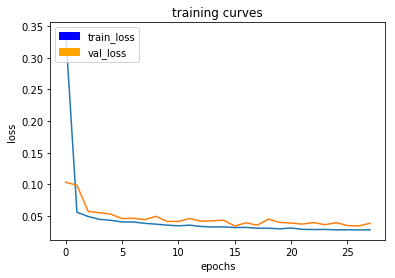

200/200 [==============================] - 1002s - loss: 0.0283 - val_loss: 0.0385
Epoch 29/80
199/200 [============================>.] - ETA: 4s - loss: 0.0273

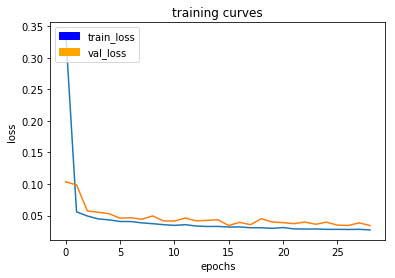

200/200 [==============================] - 1000s - loss: 0.0273 - val_loss: 0.0342
Epoch 30/80
199/200 [============================>.] - ETA: 4s - loss: 0.0269

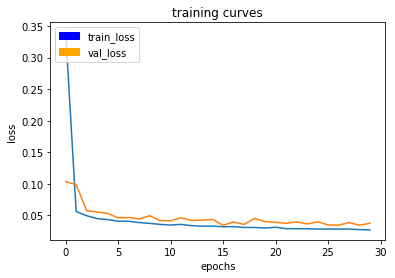

200/200 [==============================] - 1001s - loss: 0.0269 - val_loss: 0.0375
Epoch 31/80
199/200 [============================>.] - ETA: 4s - loss: 0.0273

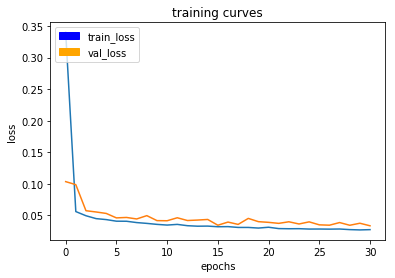

200/200 [==============================] - 1002s - loss: 0.0273 - val_loss: 0.0334
Epoch 32/80
199/200 [============================>.] - ETA: 4s - loss: 0.0272

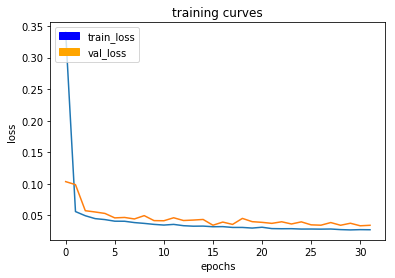

200/200 [==============================] - 1000s - loss: 0.0271 - val_loss: 0.0342
Epoch 33/80
199/200 [============================>.] - ETA: 4s - loss: 0.0271

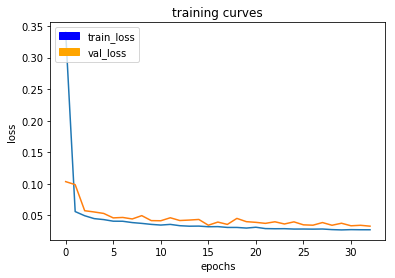

200/200 [==============================] - 1000s - loss: 0.0271 - val_loss: 0.0328
Epoch 34/80
199/200 [============================>.] - ETA: 4s - loss: 0.0264

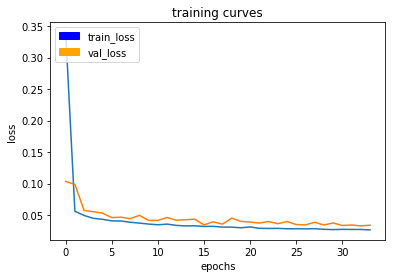

200/200 [==============================] - 1000s - loss: 0.0264 - val_loss: 0.0339
Epoch 35/80
199/200 [============================>.] - ETA: 4s - loss: 0.0257

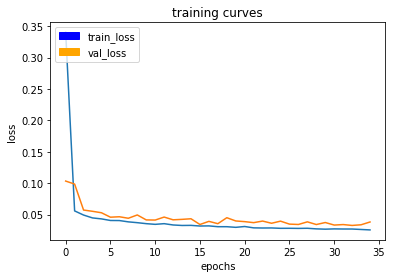

200/200 [==============================] - 1000s - loss: 0.0257 - val_loss: 0.0383
Epoch 36/80
199/200 [============================>.] - ETA: 4s - loss: 0.0259

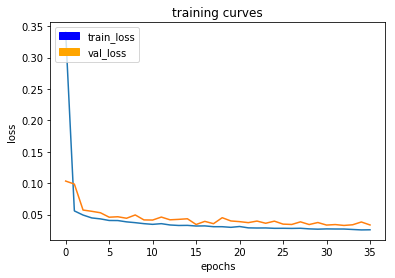

200/200 [==============================] - 999s - loss: 0.0259 - val_loss: 0.0336
Epoch 37/80
199/200 [============================>.] - ETA: 4s - loss: 0.0263

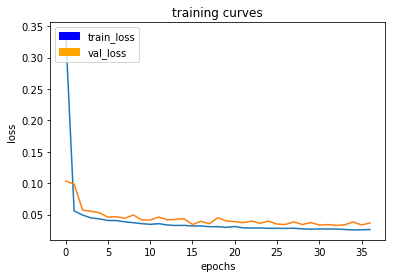

200/200 [==============================] - 1001s - loss: 0.0263 - val_loss: 0.0368
Epoch 38/80
199/200 [============================>.] - ETA: 4s - loss: 0.0262

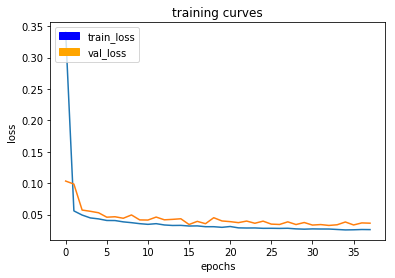

200/200 [==============================] - 1001s - loss: 0.0262 - val_loss: 0.0364
Epoch 39/80
199/200 [============================>.] - ETA: 4s - loss: 0.0259

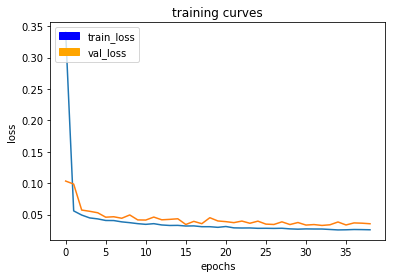

200/200 [==============================] - 1002s - loss: 0.0259 - val_loss: 0.0355
Epoch 40/80
199/200 [============================>.] - ETA: 4s - loss: 0.0256

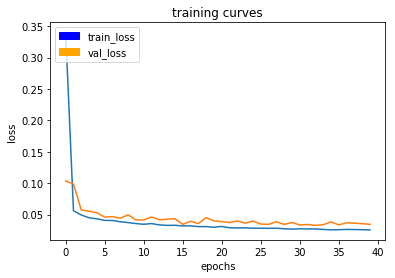

200/200 [==============================] - 1002s - loss: 0.0255 - val_loss: 0.0344
Epoch 41/80
199/200 [============================>.] - ETA: 4s - loss: 0.0254

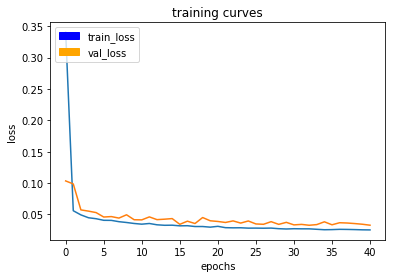

200/200 [==============================] - 1000s - loss: 0.0254 - val_loss: 0.0329
Epoch 42/80
199/200 [============================>.] - ETA: 4s - loss: 0.0262

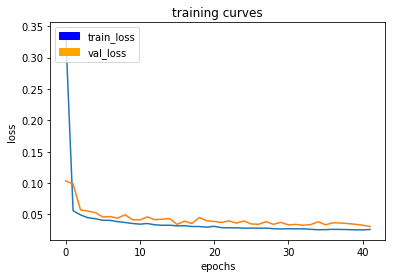

200/200 [==============================] - 1003s - loss: 0.0262 - val_loss: 0.0308
Epoch 43/80
199/200 [============================>.] - ETA: 4s - loss: 0.0252

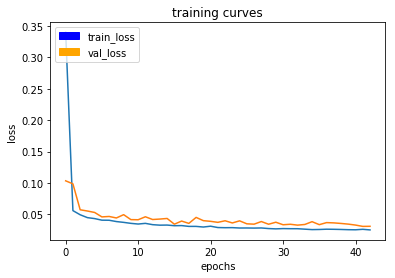

200/200 [==============================] - 1001s - loss: 0.0252 - val_loss: 0.0309
Epoch 44/80
199/200 [============================>.] - ETA: 4s - loss: 0.0246

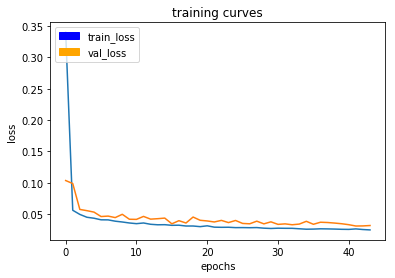

200/200 [==============================] - 1002s - loss: 0.0246 - val_loss: 0.0316
Epoch 45/80
199/200 [============================>.] - ETA: 4s - loss: 0.0247

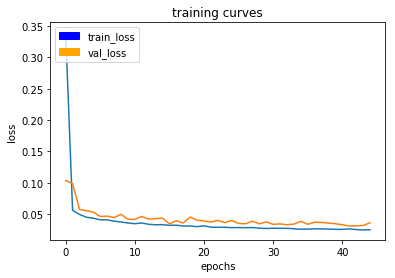

200/200 [==============================] - 1001s - loss: 0.0248 - val_loss: 0.0360
Epoch 46/80
199/200 [============================>.] - ETA: 4s - loss: 0.0254

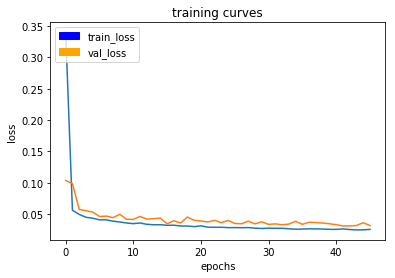

200/200 [==============================] - 1003s - loss: 0.0254 - val_loss: 0.0315
Epoch 47/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

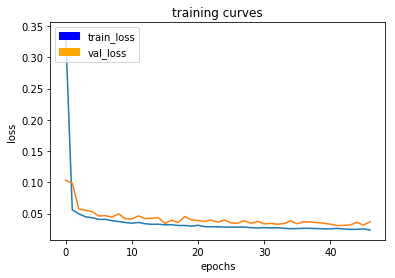

200/200 [==============================] - 1000s - loss: 0.0237 - val_loss: 0.0368
Epoch 48/80
199/200 [============================>.] - ETA: 4s - loss: 0.0253

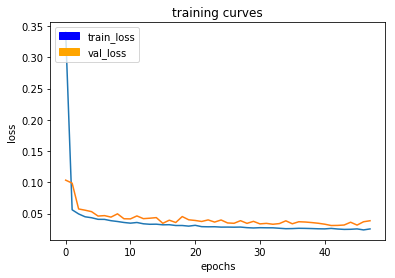

200/200 [==============================] - 1002s - loss: 0.0253 - val_loss: 0.0384
Epoch 49/80
199/200 [============================>.] - ETA: 4s - loss: 0.0239

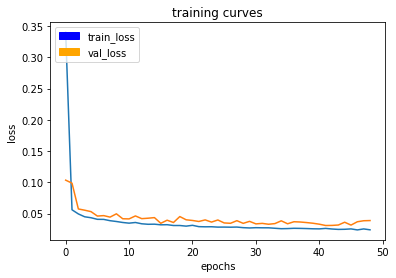

200/200 [==============================] - 1000s - loss: 0.0239 - val_loss: 0.0387
Epoch 50/80
199/200 [============================>.] - ETA: 4s - loss: 0.0245

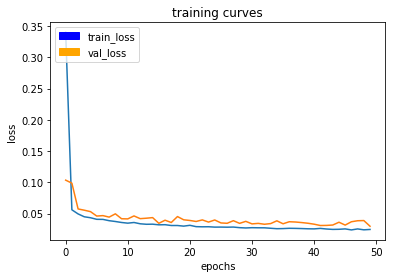

200/200 [==============================] - 1002s - loss: 0.0245 - val_loss: 0.0296
Epoch 51/80
199/200 [============================>.] - ETA: 4s - loss: 0.0243

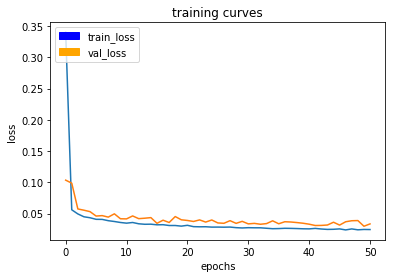

200/200 [==============================] - 1001s - loss: 0.0243 - val_loss: 0.0334
Epoch 52/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

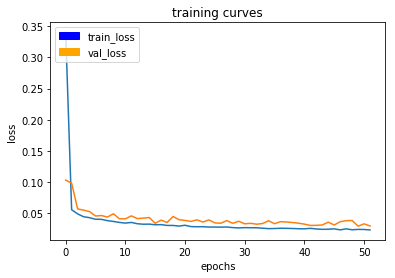

200/200 [==============================] - 999s - loss: 0.0236 - val_loss: 0.0300
Epoch 53/80
199/200 [============================>.] - ETA: 4s - loss: 0.0251

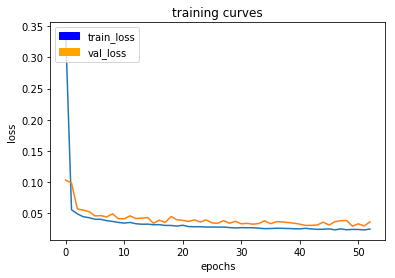

200/200 [==============================] - 1001s - loss: 0.0251 - val_loss: 0.0366
Epoch 54/80
199/200 [============================>.] - ETA: 4s - loss: 0.0245

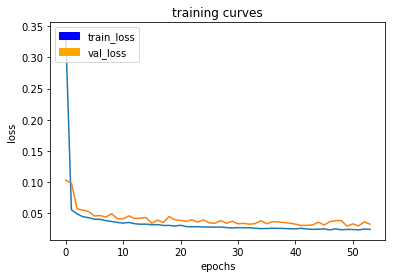

200/200 [==============================] - 998s - loss: 0.0245 - val_loss: 0.0328
Epoch 55/80
199/200 [============================>.] - ETA: 4s - loss: 0.0236

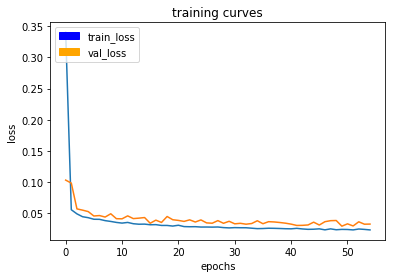

200/200 [==============================] - 1001s - loss: 0.0236 - val_loss: 0.0330
Epoch 56/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

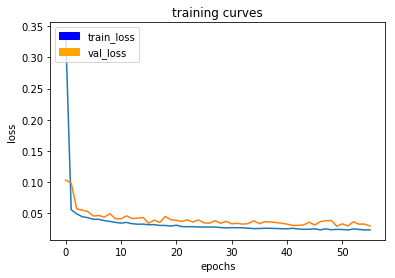

200/200 [==============================] - 1000s - loss: 0.0236 - val_loss: 0.0300
Epoch 57/80
199/200 [============================>.] - ETA: 4s - loss: 0.0233

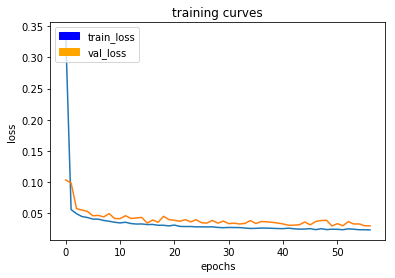

200/200 [==============================] - 1001s - loss: 0.0233 - val_loss: 0.0299
Epoch 58/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

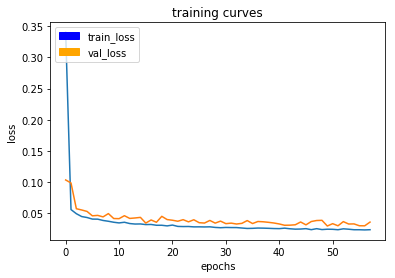

200/200 [==============================] - 1000s - loss: 0.0237 - val_loss: 0.0359
Epoch 59/80
199/200 [============================>.] - ETA: 4s - loss: 0.0236

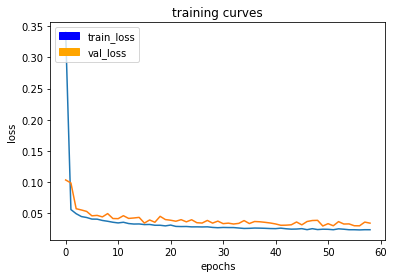

200/200 [==============================] - 1001s - loss: 0.0236 - val_loss: 0.0342
Epoch 60/80
199/200 [============================>.] - ETA: 4s - loss: 0.0228

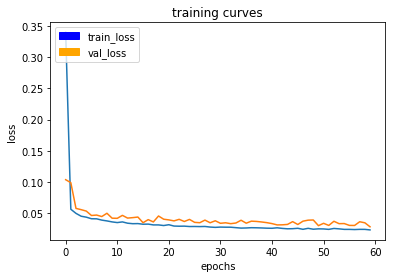

200/200 [==============================] - 1002s - loss: 0.0228 - val_loss: 0.0278
Epoch 61/80
199/200 [============================>.] - ETA: 4s - loss: 0.0227

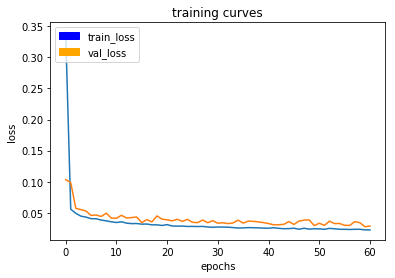

200/200 [==============================] - 1000s - loss: 0.0226 - val_loss: 0.0288
Epoch 62/80
199/200 [============================>.] - ETA: 4s - loss: 0.0238

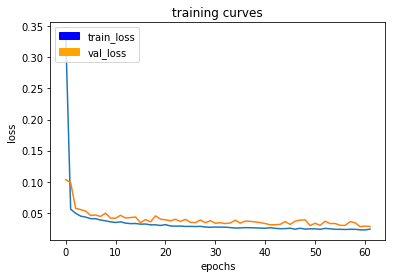

200/200 [==============================] - 1004s - loss: 0.0239 - val_loss: 0.0281
Epoch 63/80
199/200 [============================>.] - ETA: 4s - loss: 0.0225

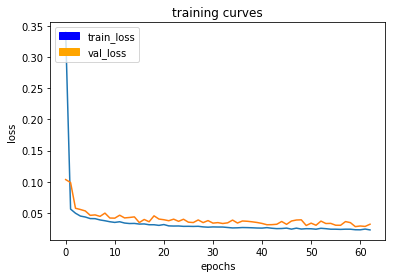

200/200 [==============================] - 999s - loss: 0.0225 - val_loss: 0.0316
Epoch 64/80
199/200 [============================>.] - ETA: 4s - loss: 0.0238

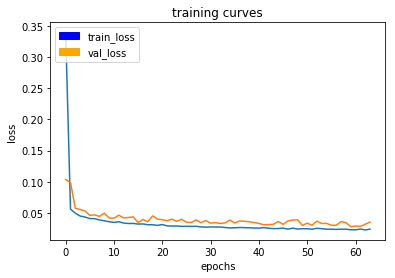

200/200 [==============================] - 1000s - loss: 0.0238 - val_loss: 0.0351
Epoch 65/80
199/200 [============================>.] - ETA: 4s - loss: 0.0237

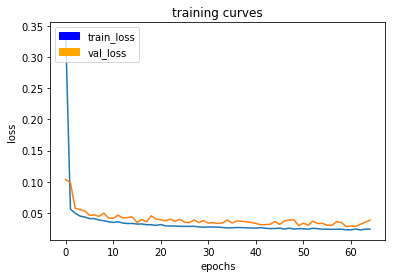

200/200 [==============================] - 999s - loss: 0.0237 - val_loss: 0.0381
Epoch 66/80
199/200 [============================>.] - ETA: 4s - loss: 0.0220

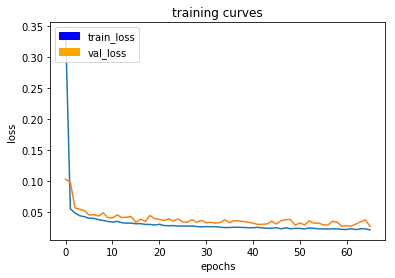

200/200 [==============================] - 1000s - loss: 0.0220 - val_loss: 0.0279
Epoch 67/80
199/200 [============================>.] - ETA: 4s - loss: 0.0231

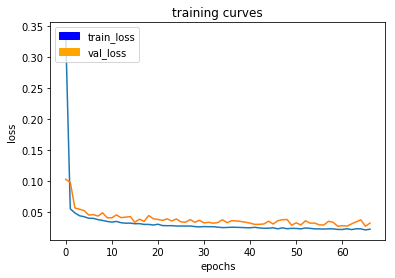

200/200 [==============================] - 1000s - loss: 0.0231 - val_loss: 0.0330
Epoch 68/80
199/200 [============================>.] - ETA: 4s - loss: 0.0246

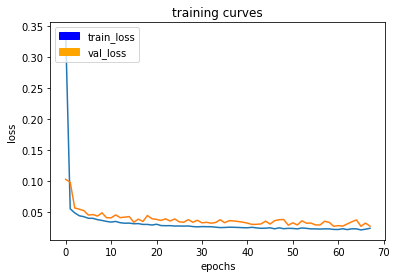

200/200 [==============================] - 1001s - loss: 0.0246 - val_loss: 0.0280
Epoch 69/80
199/200 [============================>.] - ETA: 4s - loss: 0.0226

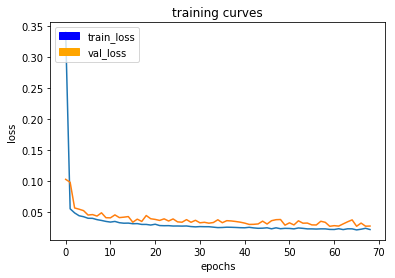

200/200 [==============================] - 1000s - loss: 0.0226 - val_loss: 0.0282
Epoch 70/80
199/200 [============================>.] - ETA: 4s - loss: 0.0215

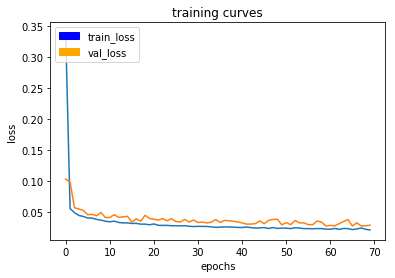

200/200 [==============================] - 1002s - loss: 0.0215 - val_loss: 0.0291
Epoch 71/80
199/200 [============================>.] - ETA: 4s - loss: 0.0233

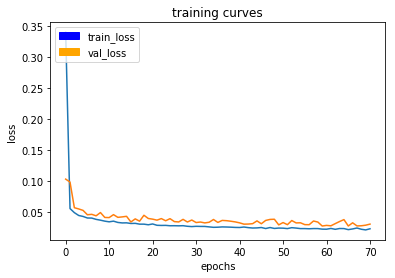

200/200 [==============================] - 1000s - loss: 0.0233 - val_loss: 0.0309
Epoch 72/80
199/200 [============================>.] - ETA: 4s - loss: 0.0222

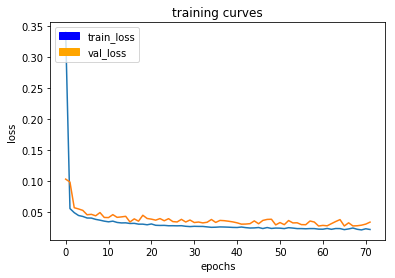

200/200 [==============================] - 1000s - loss: 0.0222 - val_loss: 0.0341
Epoch 73/80
199/200 [============================>.] - ETA: 4s - loss: 0.0233

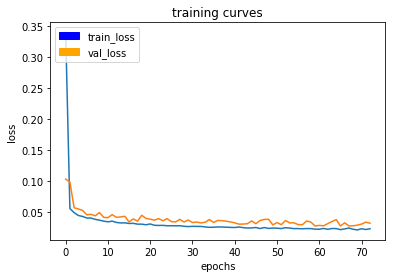

200/200 [==============================] - 1002s - loss: 0.0233 - val_loss: 0.0323
Epoch 74/80
199/200 [============================>.] - ETA: 4s - loss: 0.0221

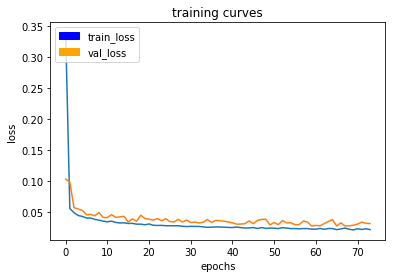

200/200 [==============================] - 999s - loss: 0.0221 - val_loss: 0.0316
Epoch 75/80
199/200 [============================>.] - ETA: 4s - loss: 0.0223

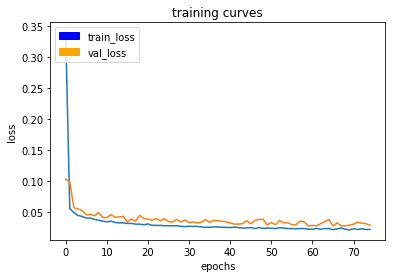

200/200 [==============================] - 1000s - loss: 0.0223 - val_loss: 0.0290
Epoch 76/80
199/200 [============================>.] - ETA: 4s - loss: 0.0220

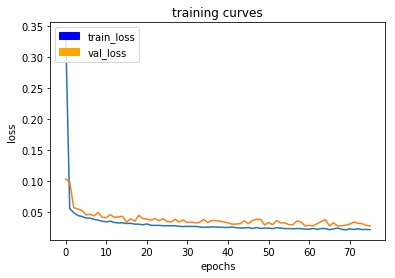

200/200 [==============================] - 1000s - loss: 0.0220 - val_loss: 0.0278
Epoch 77/80
199/200 [============================>.] - ETA: 4s - loss: 0.0229

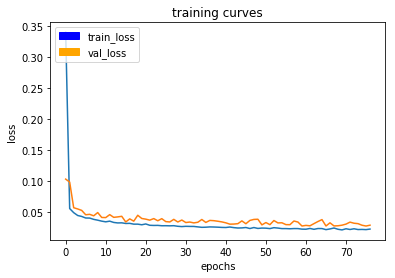

200/200 [==============================] - 1001s - loss: 0.0229 - val_loss: 0.0291
Epoch 78/80
199/200 [============================>.] - ETA: 4s - loss: 0.0225

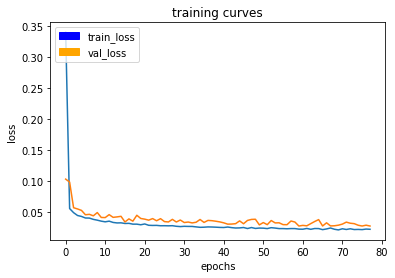

200/200 [==============================] - 1000s - loss: 0.0225 - val_loss: 0.0278
Epoch 79/80
199/200 [============================>.] - ETA: 4s - loss: 0.0224

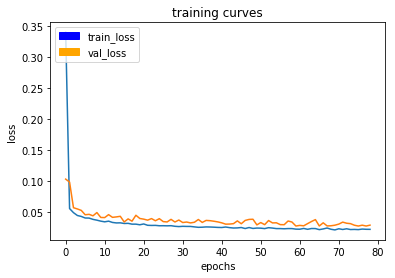

200/200 [==============================] - 1000s - loss: 0.0224 - val_loss: 0.0292
Epoch 80/80
199/200 [============================>.] - ETA: 4s - loss: 0.0215

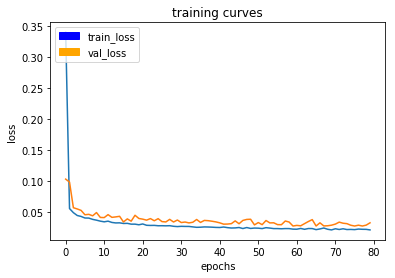

200/200 [==============================] - 1000s - loss: 0.0215 - val_loss: 0.0329


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

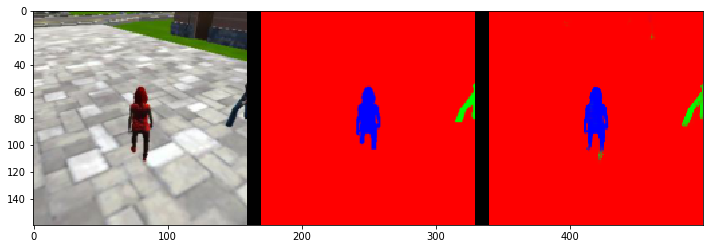

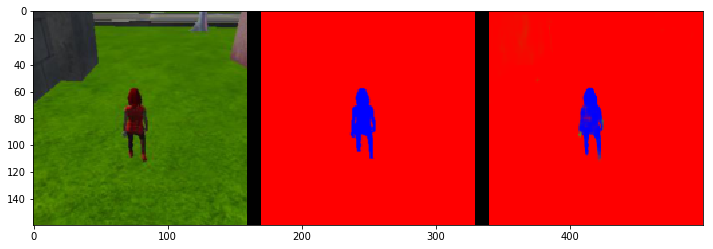

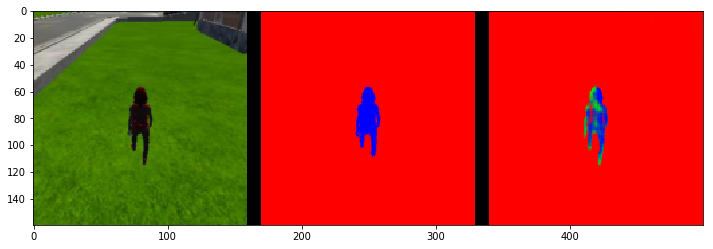

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

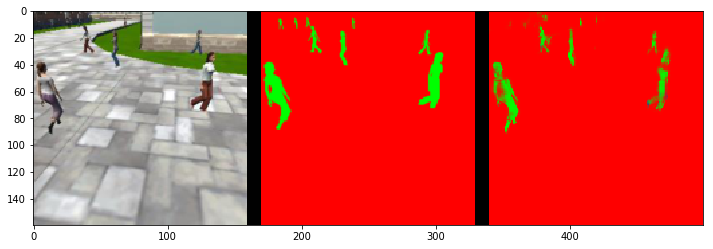

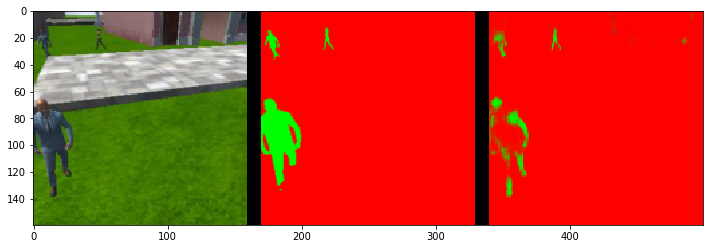

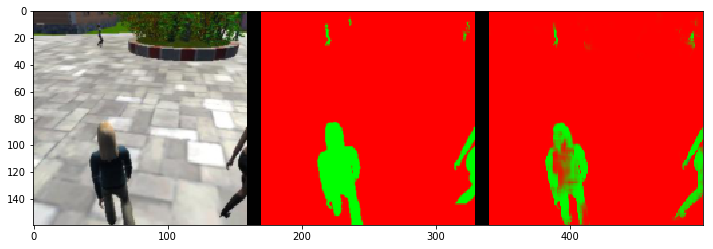

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

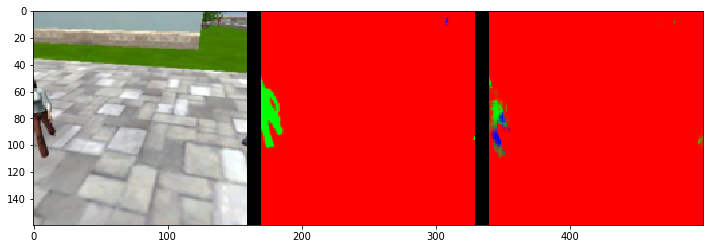

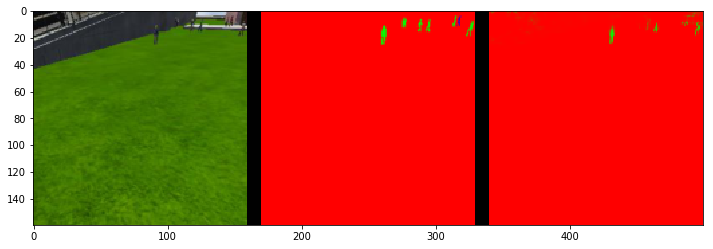

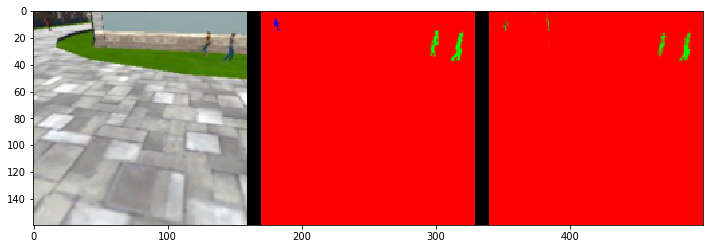

In [16]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9945938801517964
average intersection over union for other people is 0.2995189912536814
average intersection over union for the hero is 0.8409932484284489
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9791749415582147
average intersection over union for other people is 0.5709850326205995
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 58, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9956217426043961
average intersection over union for other people is 0.39195770671009034
average intersection over union for the hero is 0.170921151479286
number true positives: 126, number false positives: 1, number false negatives: 175


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7397107897664071


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5059571999538675


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.3742619999658753
